# Convert whole_df to features_df

In [3]:
from preprocessing.feature_engineering import extract_domain_features
import os

# 设置路径
data_folder = "data/datasets"
save_folder_dir = "data/features_df"


os.makedirs(save_folder_dir, exist_ok=True)

file_list = os.listdir(data_folder)

sid_list = sorted([
    filename.split("_")[0]
    for filename in file_list
    if filename.endswith("_whole_df.csv") and filename.startswith("S")
])


In [4]:
from preprocessing.feature_engineering import extract_domain_features
import os
from multiprocessing import Pool, cpu_count

# Set input and output directories
data_folder = "data/datasets"
save_folder_dir = "data/features_df"

# Create output directory if it doesn't exist
os.makedirs(save_folder_dir, exist_ok=True)

# Detect available whole_df files (SXXX_whole_df.csv)
sid_list = sorted([
    filename.split("_")[0]
    for filename in os.listdir(data_folder)
    if filename.endswith("_whole_df.csv") and filename.startswith("S")
])

# Check which domain_features_df files already exist
existing_feature_files = {
    f.split("_domain_features_df.csv")[0]
    for f in os.listdir(save_folder_dir)
    if f.endswith("_domain_features_df.csv")
}

# Only process files that have not yet been converted
pending_sid_list = [sid for sid in sid_list if sid not in existing_feature_files]

print(f" Found {len(sid_list)} whole_df files.")
print(f" {len(existing_feature_files)} domain feature files already exist.")
print(f" {len(pending_sid_list)} SIDs pending for processing.")

def process_sid(sid):
    print(f" Processing {sid}...")
    try:
        extract_domain_features(
            sid=sid,
            data_folder=data_folder,
            save_folder_dir=save_folder_dir,
            segment_seconds=30
        )
        print(f" {sid} completed successfully.")
        return (sid, "success")
    except Exception as e:
        print(f" {sid} failed with error: {str(e)}")
        return (sid, f"error: {str(e)}")


 Found 100 whole_df files.
 100 domain feature files already exist.
 0 SIDs pending for processing.


In [5]:
# Use up to 8 CPU cores or as many as available
num_processes = min(cpu_count(), 8)
print(f" Starting parallel processing with {num_processes} processes...")

with Pool(processes=num_processes) as pool:
    results = pool.map(process_sid, pending_sid_list)


 Starting parallel processing with 8 processes...


In [6]:
# Summarize success/failure
success_sids = [sid for sid, status in results if status == "success"]
error_sids = [sid for sid, status in results if "error" in status]

print(f"\n Summary:")
print(f"{len(success_sids)} succeeded")
print(f"{len(error_sids)} failed")

if error_sids:
    print("Failed SIDs:")
    for sid in error_sids:
        print(f" - {sid}")


 Summary:
0 succeeded
0 failed


# Data Preparation

In [7]:
import pandas as pd
import numpy as np
import random
import warnings
from preprocessing.datasets import *


warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set display options
pd.set_option("display.max_rows", 500)  # Replace 500 with your desired number of rows
pd.set_option(
    "display.max_columns", 10
)  # Replace 10 with your desired number of columns
pd.set_option("display.width", 1000)  # Adjust the width as needed
pd.set_option("display.max_colwidth", 50)  # Adjust the column width as needed

In [8]:
def calculate_quality_scores(feature_path='data/features_df/', output_path='data/quality_scores_per_subject.csv'):
    files = os.listdir(feature_path)
    files.sort()

    sids = []
    total_segments = []
    num_excludes = []
    percentages = []

    for file in files:
        sid = file.split('_')[0]
        file_path = os.path.join(feature_path, file)
        df = pd.read_csv(file_path)
        segment_len = len(df)
        segment_exclude = np.sum(df.artifact)
        percentage = segment_exclude / segment_len

        sids.append(sid)
        total_segments.append(segment_len)
        num_excludes.append(segment_exclude)
        percentages.append(percentage)

    qs = pd.DataFrame({
        'sid': sids,
        'total_segments': total_segments,
        'num_excludes': num_excludes,
        'percentage_excludes': percentages
    })

    qs.to_csv(output_path, index=False)
    return qs
    
qs_df = calculate_quality_scores()
qs_df.head()

,sid,total_segments,num_excludes,percentage_excludes
0,S002,1048,362,0.345420
1,S003,1068,138,0.129213
2,S004,1032,78,0.075581
3,S005,1037,25,0.024108
4,S006,1113,37,0.033243


In [9]:
# Prepare the data
quality_df_dir = 'data/quality_scores_per_subject.csv'
features_dir = "data/features_df/"
info_dir = "data/participant_info.csv"
clean_df, new_features, good_quality_sids = data_preparation(
    threshold = 0.2, 
    quality_df_dir = quality_df_dir,
    features_dir = features_dir,
    info_dir = info_dir)
print(clean_df.shape)
print(len(new_features))

(77528, 595)
582


In [11]:
clean_df

,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,...,Hypopnea,Multiple_Events,artifact,sid,BMI
1,87.451445,706.554878,267.856258,351.154277,355.627540,...,0.0,0.0,0,S003,51.0
2,84.687304,729.296875,280.299933,416.686698,422.114301,...,0.0,0.0,1,S003,51.0
3,90.889185,675.872093,224.392912,307.124526,310.704819,...,0.0,0.0,1,S003,51.0
4,79.140186,783.361486,303.274460,394.236775,399.794171,...,0.0,0.0,1,S003,51.0
5,90.383327,697.265625,297.089740,386.889187,391.164017,...,0.0,0.0,1,S003,51.0
...,...,...,...,...,...,...,...,...,...,...,...
80723,61.392727,982.219828,132.432765,154.679608,157.518003,...,0.0,0.0,0,S102,26.0
80724,61.198295,984.375000,138.500822,128.032414,130.376875,...,0.0,0.0,0,S102,26.0
80725,57.181574,1049.189815,18.233936,23.337125,23.799291,...,0.0,0.0,0,S102,26.0
80726,57.535505,1042.824074,17.652470,18.889704,19.224759,...,0.0,0.0,0,S102,26.0


# Correlation

In [12]:
import json


clean_df.to_csv("data/processed/clean_df.csv", index=False)


clean_df.to_pickle("data/processed/clean_df.pkl")


with open("data/processed/new_features.json", "w") as f:
    json.dump(new_features, f)


with open("data/processed/good_quality_sids.txt", "w") as f:
    for sid in good_quality_sids:
        f.write(sid + "\n")


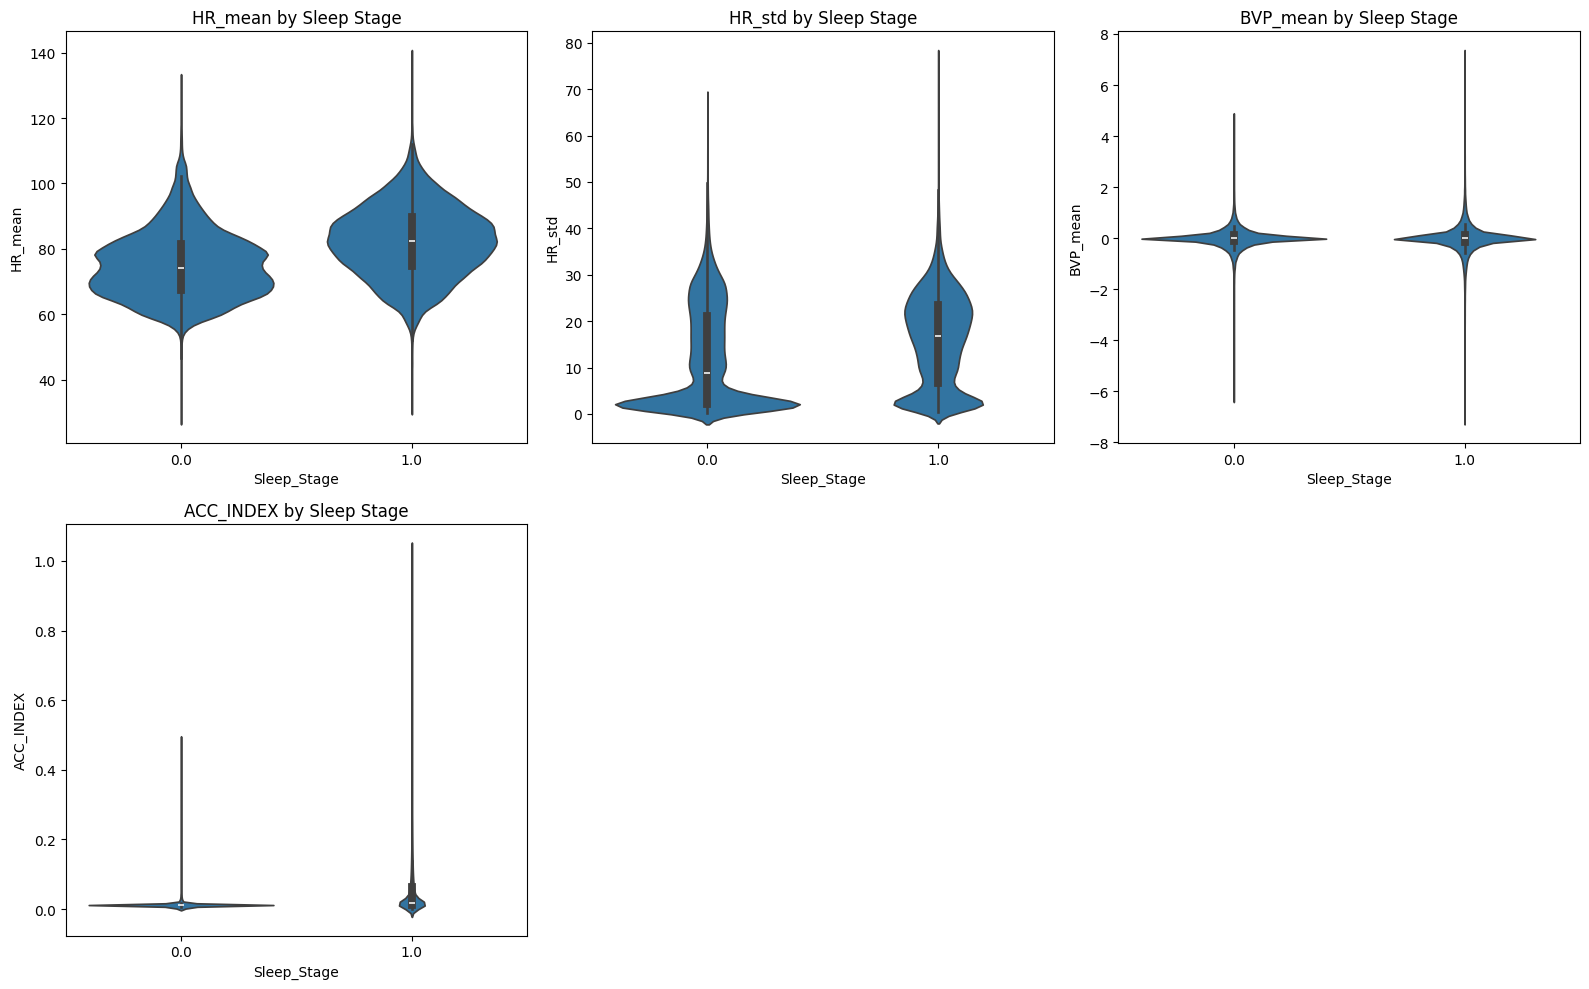

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clean_df=pd.read_csv("data/processed/clean_df.csv")
features_to_plot = ["HR_mean", "HR_std", "BVP_mean", "ACC_INDEX"]
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.violinplot(x='Sleep_Stage', y=feature, data=clean_df)
    plt.title(f'{feature} by Sleep Stage')
    plt.tight_layout()
plt.show()


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_by_sleep_stage(df, keyword, n_cols=3):
    """
    Plot boxplots of all features containing the keyword against Sleep_Stage.

    Parameters:
        df (pd.DataFrame): the cleaned dataframe.
        keyword (str): keyword to filter features (e.g., 'TEMP', 'HRV').
        n_cols (int): number of columns in subplot layout.
    """
    # 选择对应关键词的特征
    matched_features = [col for col in df.columns if keyword in col and df[col].dtype != 'object']

    if not matched_features:
        print(f"No features found with keyword '{keyword}'")
        return

    n_rows = (len(matched_features) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 6, n_rows * 4))

    for i, feature in enumerate(matched_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x='Sleep_Stage', y=feature, data=df)
        plt.title(feature)
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.suptitle(f"Features related to '{keyword}' vs Sleep_Stage", y=1.02, fontsize=16)
    plt.show()


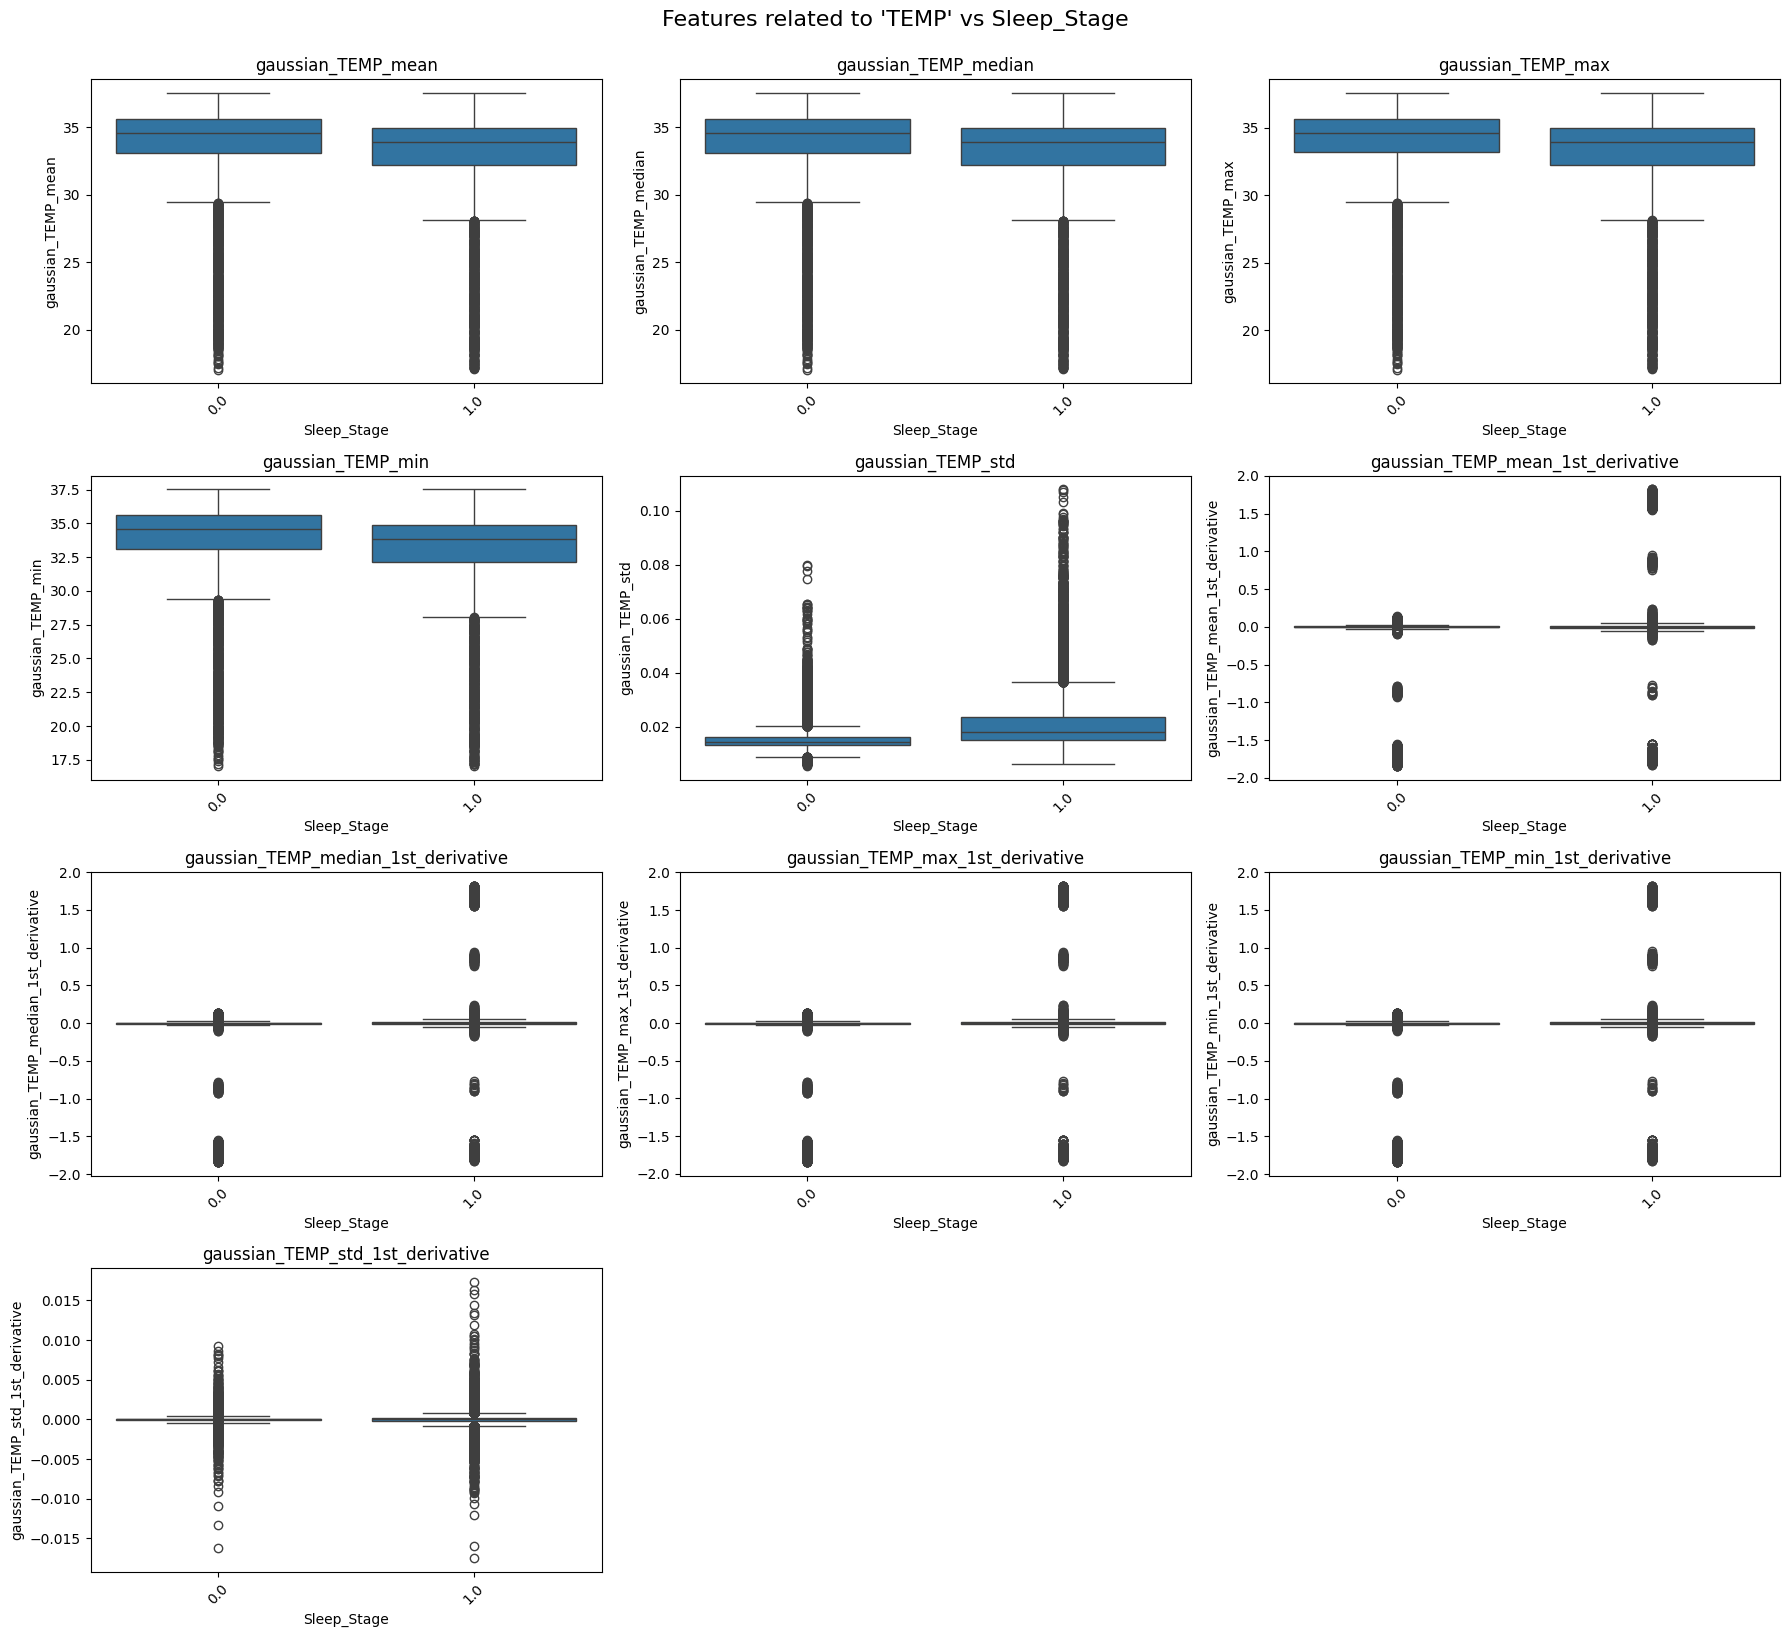

In [15]:
plot_features_by_sleep_stage(clean_df, keyword='TEMP')
